# **Análisis del modelo más equilibrado**

El modelo seleccionado (XGBoost Log) ofrece la mejor precisión general en términos porcentuales (MAPE). Sin embargo, se observa una ligera tendencia a infraestimar los valores en el decil más alto de la distribución (valores > 40,000). Esto es una consecuencia esperada de la transformación logarítmica utilizada para estabilizar la varianza.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import shap

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

from functions.preparation import data_version_b

In [3]:
path_no_outliers_data = "../data/processed/no_outliers_data.csv"

# Dataset version C (para decision tree, random forest, XGBoost y LightGBM pero con y_train con Log)
(X_train_c,
 X_test_c,
 y_train_c,
 y_test_c,
 global_mean_c,
 maps_encoding_c,
 features_c, numerical_columns_c) = data_version_b(path_no_outliers_data, log_transformed=True)

In [4]:
# XGBoost Log - Dataset C
path_file_xgboost_log = "../models/xgboost_log.pkl"

model_xgb_log = joblib.load(path_file_xgboost_log)["model"]

y_pred_xgb_log_scaled = model_xgb_log.predict(X_test_c)
y_pred_xgb_log = np.expm1(y_pred_xgb_log_scaled)



## **Explicabilidad**

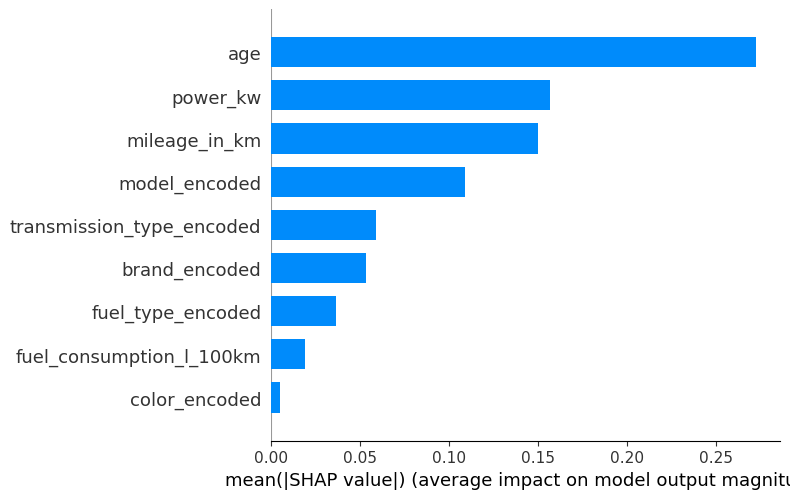

In [5]:
shap.initjs()

# Crear explicador SHAP
explainer = shap.Explainer(model_xgb_log)

# Calcular valores SHAP sobre el conjunto de prueba
shap_values = explainer(X_test_c)

# Mostrar resumen de importancia de características
shap.summary_plot(shap_values, X_test_c, plot_type="bar")


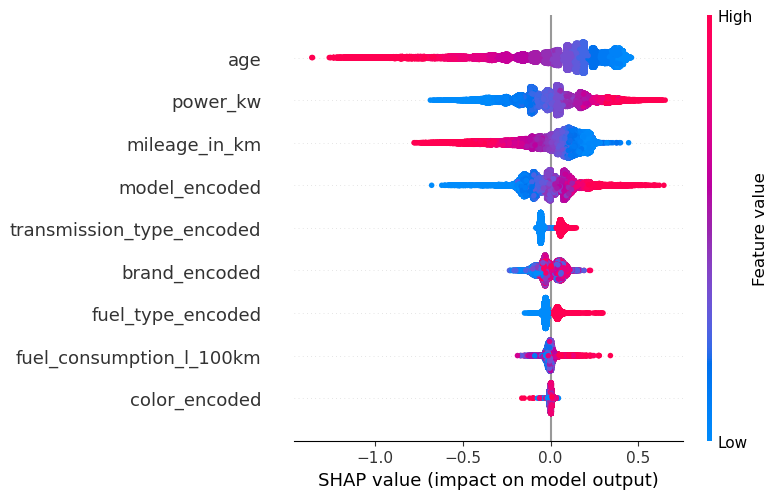

In [6]:
# Graficar Beeswarm Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_c)

## **Análisis de errores**

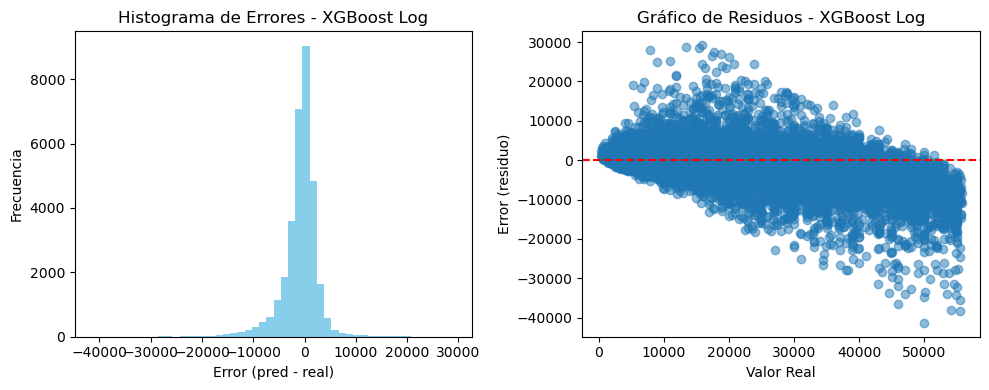

In [7]:
# Función para comparar diferentes visualizaciones del error
def plot_error_distributions(name, y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    errors = y_pred - y_true  # Residuos

    plt.figure(figsize=(10,4))

    # Histograma de errores
    plt.subplot(1, 2, 1)
    plt.hist(errors, bins=50, color="skyblue", density=False)
    plt.title(f"Histograma de Errores - {name}")
    plt.xlabel("Error (pred - real)")
    plt.ylabel("Frecuencia")


    # Gráfico de residuos
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Gráfico de Residuos - {name}")
    plt.xlabel("Valor Real")
    plt.ylabel("Error (residuo)")

    plt.tight_layout()
    plt.show()

# Visualización completa de errores para el mejor modelo
plot_error_distributions("XGBoost Log", y_test_c, y_pred_xgb_log)

In [8]:
# Crear un DataFrame de diagnóstico
df_diag = X_test_c.copy()
df_diag['real'] = y_test_c
df_diag['pred'] = y_pred_xgb_log
df_diag['error_abs'] = abs(df_diag['real'] - df_diag['pred'])
df_diag['error_rel_%'] = (df_diag['error_abs'] / df_diag['real']) * 100
df_diag['residuo'] = df_diag['pred'] - df_diag['real']

# Definir el umbral del segmento "Alto Valor" (basado en tu observación de la curva)
umbral = 40000
segmento_alto = df_diag[df_diag['real'] > umbral]
segmento_estandar = df_diag[df_diag['real'] <= umbral]

# Comparar métricas
print(f"--- Análisis por Segmentos ---")
print(f"Segmento Estándar (<= {umbral}):")
print(f"  MAPE: {segmento_estandar['error_rel_%'].mean():.2f}%")
print(f"  Sesgo Promedio (Residuo): {segmento_estandar['residuo'].mean():.2f}")

print(f"\nSegmento Alto Valor (> {umbral}):")
print(f"  MAPE: {segmento_alto['error_rel_%'].mean():.2f}%")
print(f"  Sesgo Promedio (Residuo): {segmento_alto['residuo'].mean():.2f}") 

--- Análisis por Segmentos ---
Segmento Estándar (<= 40000):
  MAPE: 13.60%
  Sesgo Promedio (Residuo): -410.10

Segmento Alto Valor (> 40000):
  MAPE: 14.85%
  Sesgo Promedio (Residuo): -6865.29



Importancia de variables para el Segmento de Alto Valor:


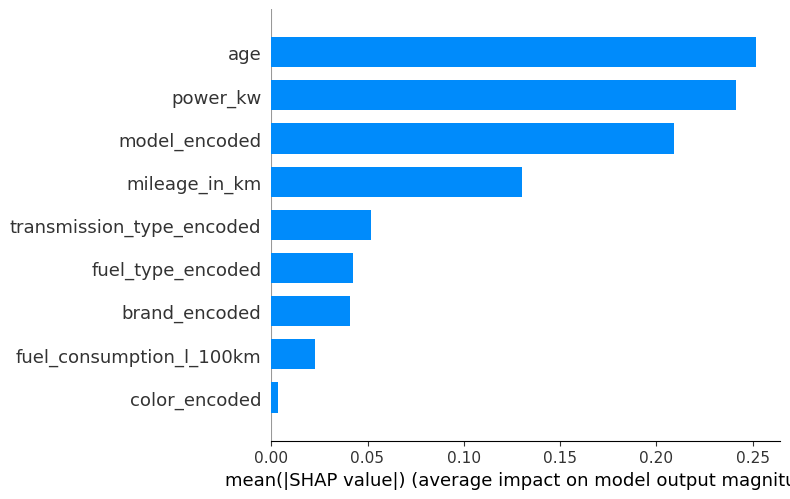

In [9]:
# Índices del segmento alto
idx_alto = segmento_alto.index

# Obtener los valores SHAP específicos para esos registros
# Nota: Suponiendo que X_test_c y shap_values mantienen el mismo orden/índice
shap_values_alto = shap_values[df_diag.index.get_indexer(idx_alto)]

print("\nImportancia de variables para el Segmento de Alto Valor:")
shap.summary_plot(shap_values_alto, X_test_c.loc[idx_alto], plot_type="bar")